In [1]:
import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline  

from heatmap_estimator import HeatmapEstimator
from projection_dataset import ProjectionDataset
%load_ext autoreload
%autoreload 2

In [2]:
dataset_dir = "../data/projections"
plane = "XY" # Other planes: YZ and ZX
model_path = "../models/" + plane + ".pth"

In [3]:
train_subjects = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
train_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
train_dataset = ProjectionDataset(dataset_dir, train_subjects, train_gestures, plane, False)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

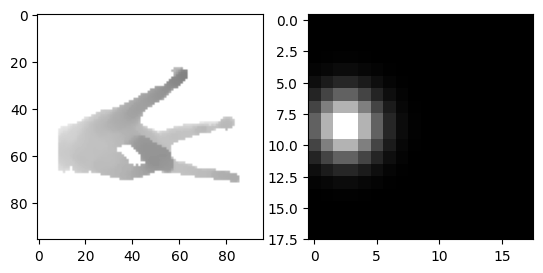

In [4]:
# Visualize sample
image, heatmap_gt = next(iter(train_dataloader))

fig, (plt1, plt2) = plt.subplots(1, 2)
plt1.imshow(torch.squeeze(image[0], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt2.imshow(torch.squeeze(heatmap_gt[0][0], 0).numpy(), cmap='gray', vmin=0, vmax=1)

In [7]:
val_subjects = ["P0"]
val_gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]
val_dataset = ProjectionDataset(dataset_dir, val_subjects, val_gestures, plane, False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [8]:
# Load the model
device = 'cuda'
model = HeatmapEstimator().to(device)

In [9]:
# Configure the optimizer and criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.MSELoss()

Computing epoch 0
Minibatch 0 Loss = 0.03560438
Minibatch 50 Loss = 0.02474602
Minibatch 100 Loss = 0.02495137
Minibatch 150 Loss = 0.02444001
Minibatch 200 Loss = 0.02483416
Minibatch 250 Loss = 0.02467364
Plotting sample validation figures


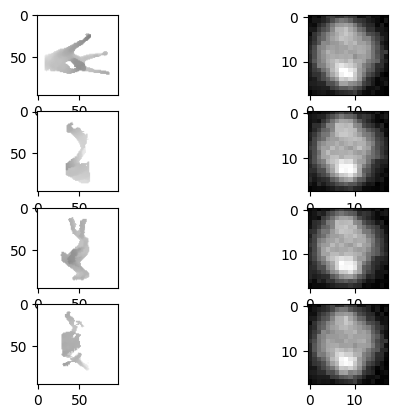

Epoch 0: Training Loss = 0.02562653, Validation Loss = 0.02503016
Computing epoch 1
Minibatch 0 Loss = 0.02451580
Minibatch 50 Loss = 0.02452772
Minibatch 100 Loss = 0.02421058
Minibatch 150 Loss = 0.02426840
Minibatch 200 Loss = 0.02460150
Minibatch 250 Loss = 0.02452365
Epoch 1: Training Loss = 0.02464431, Validation Loss = 0.02498596
Computing epoch 2
Minibatch 0 Loss = 0.02454412
Minibatch 50 Loss = 0.02463993
Minibatch 100 Loss = 0.02442310
Minibatch 150 Loss = 0.02461731
Minibatch 200 Loss = 0.02463191
Minibatch 250 Loss = 0.02471155
Epoch 2: Training Loss = 0.02462632, Validation Loss = 0.02497423
Computing epoch 3
Minibatch 0 Loss = 0.02436860
Minibatch 50 Loss = 0.02461101
Minibatch 100 Loss = 0.02443755
Minibatch 150 Loss = 0.02502205
Minibatch 200 Loss = 0.02472302
Minibatch 250 Loss = 0.02460895
Epoch 3: Training Loss = 0.02460406, Validation Loss = 0.02495934
Computing epoch 4
Minibatch 0 Loss = 0.02461962
Minibatch 50 Loss = 0.02450962
Minibatch 100 Loss = 0.02419778
Mini

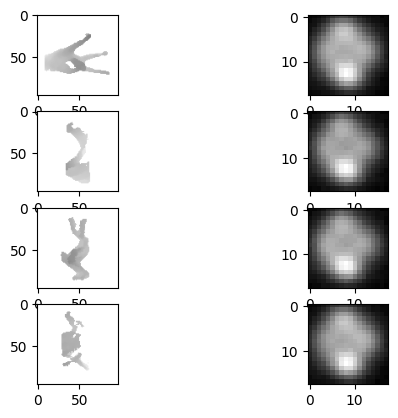

Epoch 5: Training Loss = 0.02448813, Validation Loss = 0.02477329
Computing epoch 6
Minibatch 0 Loss = 0.02436841
Minibatch 50 Loss = 0.02455940
Minibatch 100 Loss = 0.02427084
Minibatch 150 Loss = 0.02423757
Minibatch 200 Loss = 0.02424622
Minibatch 250 Loss = 0.02403242
Epoch 6: Training Loss = 0.02421898, Validation Loss = 0.02426101
Computing epoch 7
Minibatch 0 Loss = 0.02411843
Minibatch 50 Loss = 0.02361538
Minibatch 100 Loss = 0.02361860
Minibatch 150 Loss = 0.02365698
Minibatch 200 Loss = 0.02334387
Minibatch 250 Loss = 0.02318350
Epoch 7: Training Loss = 0.02362278, Validation Loss = 0.02370770
Computing epoch 8
Minibatch 0 Loss = 0.02382471
Minibatch 50 Loss = 0.02362857
Minibatch 100 Loss = 0.02327911
Minibatch 150 Loss = 0.02311605
Minibatch 200 Loss = 0.02332281
Minibatch 250 Loss = 0.02329835
Epoch 8: Training Loss = 0.02335564, Validation Loss = 0.02358779
Computing epoch 9
Minibatch 0 Loss = 0.02348917
Minibatch 50 Loss = 0.02339833
Minibatch 100 Loss = 0.02321620
Mini

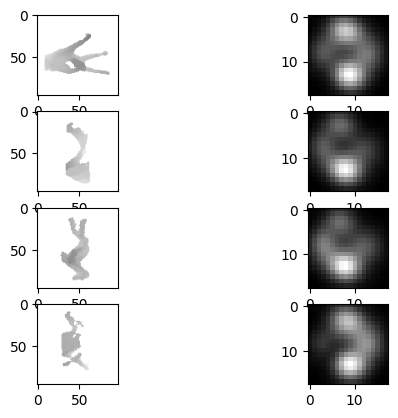

Epoch 10: Training Loss = 0.02326095, Validation Loss = 0.02358023
Computing epoch 11
Minibatch 0 Loss = 0.02397917
Minibatch 50 Loss = 0.02340755
Minibatch 100 Loss = 0.02321331
Minibatch 150 Loss = 0.02328541
Minibatch 200 Loss = 0.02333250
Minibatch 250 Loss = 0.02322413
Epoch 11: Training Loss = 0.02324468, Validation Loss = 0.02352442
Computing epoch 12
Minibatch 0 Loss = 0.02330287
Minibatch 50 Loss = 0.02337201
Minibatch 100 Loss = 0.02319150
Minibatch 150 Loss = 0.02320255
Minibatch 200 Loss = 0.02296607
Minibatch 250 Loss = 0.02316568
Epoch 12: Training Loss = 0.02321103, Validation Loss = 0.02346243
Computing epoch 13
Minibatch 0 Loss = 0.02304970
Minibatch 50 Loss = 0.02336859
Minibatch 100 Loss = 0.02319734
Minibatch 150 Loss = 0.02329596
Minibatch 200 Loss = 0.02307567
Minibatch 250 Loss = 0.02339469
Epoch 13: Training Loss = 0.02319048, Validation Loss = 0.02339227
Computing epoch 14
Minibatch 0 Loss = 0.02305269
Minibatch 50 Loss = 0.02320889
Minibatch 100 Loss = 0.02334

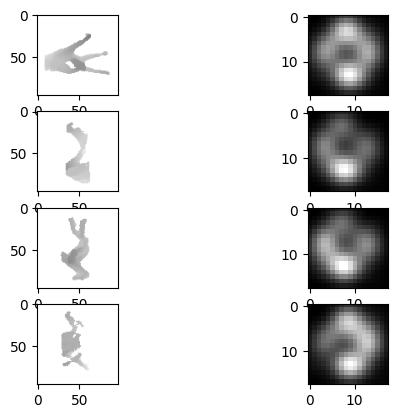

Epoch 15: Training Loss = 0.02313633, Validation Loss = 0.02335673
Computing epoch 16
Minibatch 0 Loss = 0.02319739
Minibatch 50 Loss = 0.02321033
Minibatch 100 Loss = 0.02314144
Minibatch 150 Loss = 0.02318220
Minibatch 200 Loss = 0.02316831
Minibatch 250 Loss = 0.02271166
Epoch 16: Training Loss = 0.02311125, Validation Loss = 0.02338893
Computing epoch 17
Minibatch 0 Loss = 0.02281360
Minibatch 50 Loss = 0.02301570
Minibatch 100 Loss = 0.02321789
Minibatch 150 Loss = 0.02310082
Minibatch 200 Loss = 0.02298362
Minibatch 250 Loss = 0.02300050
Epoch 17: Training Loss = 0.02309043, Validation Loss = 0.02338538
Computing epoch 18
Minibatch 0 Loss = 0.02252024
Minibatch 50 Loss = 0.02316421
Minibatch 100 Loss = 0.02306036
Minibatch 150 Loss = 0.02313822
Minibatch 200 Loss = 0.02308455
Minibatch 250 Loss = 0.02299550
Epoch 18: Training Loss = 0.02307363, Validation Loss = 0.02328752
Computing epoch 19
Minibatch 0 Loss = 0.02307167
Minibatch 50 Loss = 0.02329003
Minibatch 100 Loss = 0.02286

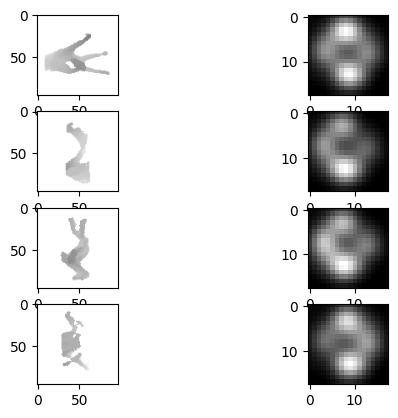

Epoch 20: Training Loss = 0.02303446, Validation Loss = 0.02329801
Computing epoch 21
Minibatch 0 Loss = 0.02327995
Minibatch 50 Loss = 0.02279227
Minibatch 100 Loss = 0.02321411
Minibatch 150 Loss = 0.02259191
Minibatch 200 Loss = 0.02303715
Minibatch 250 Loss = 0.02293932
Epoch 21: Training Loss = 0.02301006, Validation Loss = 0.02328463
Computing epoch 22
Minibatch 0 Loss = 0.02290072
Minibatch 50 Loss = 0.02277416
Minibatch 100 Loss = 0.02269238
Minibatch 150 Loss = 0.02292264
Minibatch 200 Loss = 0.02272557
Minibatch 250 Loss = 0.02293719
Epoch 22: Training Loss = 0.02300574, Validation Loss = 0.02328261
Computing epoch 23
Minibatch 0 Loss = 0.02281471
Minibatch 50 Loss = 0.02297898
Minibatch 100 Loss = 0.02318017
Minibatch 150 Loss = 0.02302563
Minibatch 200 Loss = 0.02283958
Minibatch 250 Loss = 0.02297326
Epoch 23: Training Loss = 0.02298245, Validation Loss = 0.02326753
Computing epoch 24
Minibatch 0 Loss = 0.02362518
Minibatch 50 Loss = 0.02309190
Minibatch 100 Loss = 0.02287

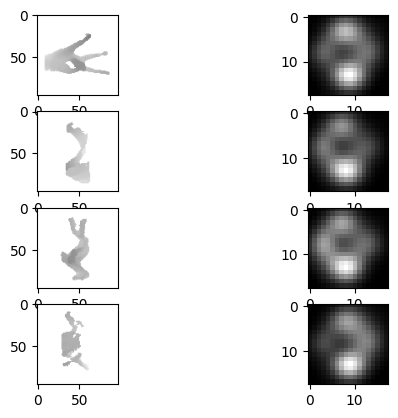

Epoch 25: Training Loss = 0.02296723, Validation Loss = 0.02326150
Computing epoch 26
Minibatch 0 Loss = 0.02286502
Minibatch 50 Loss = 0.02315030
Minibatch 100 Loss = 0.02274883
Minibatch 150 Loss = 0.02314930
Minibatch 200 Loss = 0.02273916
Minibatch 250 Loss = 0.02304722
Epoch 26: Training Loss = 0.02295326, Validation Loss = 0.02317218
Computing epoch 27
Minibatch 0 Loss = 0.02271433
Minibatch 50 Loss = 0.02325548
Minibatch 100 Loss = 0.02313390
Minibatch 150 Loss = 0.02293473
Minibatch 200 Loss = 0.02328945
Minibatch 250 Loss = 0.02254714
Epoch 27: Training Loss = 0.02295072, Validation Loss = 0.02329996
Computing epoch 28
Minibatch 0 Loss = 0.02319531
Minibatch 50 Loss = 0.02324799
Minibatch 100 Loss = 0.02299935
Minibatch 150 Loss = 0.02270452
Minibatch 200 Loss = 0.02318686
Minibatch 250 Loss = 0.02312317
Epoch 28: Training Loss = 0.02295477, Validation Loss = 0.02320137
Computing epoch 29
Minibatch 0 Loss = 0.02297762
Minibatch 50 Loss = 0.02297069
Minibatch 100 Loss = 0.02291

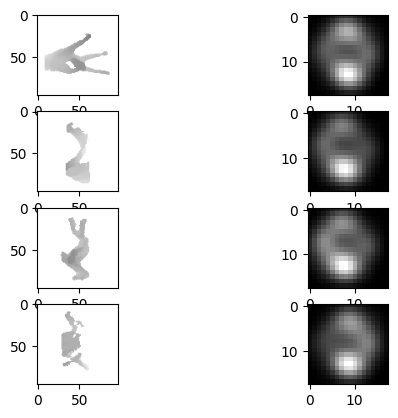

Epoch 30: Training Loss = 0.02293549, Validation Loss = 0.02317509
Computing epoch 31
Minibatch 0 Loss = 0.02306012
Minibatch 50 Loss = 0.02264421
Minibatch 100 Loss = 0.02311422
Minibatch 150 Loss = 0.02290296
Minibatch 200 Loss = 0.02273182
Minibatch 250 Loss = 0.02352288
Epoch 31: Training Loss = 0.02292013, Validation Loss = 0.02331442
Computing epoch 32
Minibatch 0 Loss = 0.02284515
Minibatch 50 Loss = 0.02311788
Minibatch 100 Loss = 0.02277131
Minibatch 150 Loss = 0.02261765
Minibatch 200 Loss = 0.02225707
Minibatch 250 Loss = 0.02262015
Epoch 32: Training Loss = 0.02291903, Validation Loss = 0.02318324
Computing epoch 33
Minibatch 0 Loss = 0.02273484
Minibatch 50 Loss = 0.02262019
Minibatch 100 Loss = 0.02300392
Minibatch 150 Loss = 0.02288787
Minibatch 200 Loss = 0.02292296
Minibatch 250 Loss = 0.02290560
Epoch 33: Training Loss = 0.02288841, Validation Loss = 0.02322450
Computing epoch 34
Minibatch 0 Loss = 0.02318504
Minibatch 50 Loss = 0.02284924
Minibatch 100 Loss = 0.02315

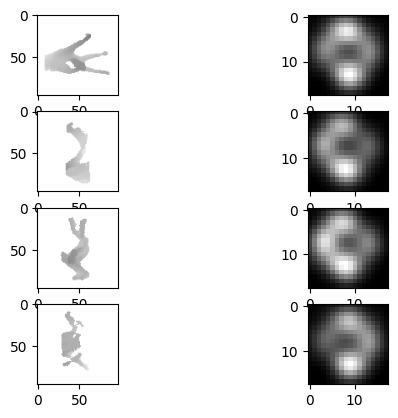

Epoch 35: Training Loss = 0.02288508, Validation Loss = 0.02328128
Computing epoch 36
Minibatch 0 Loss = 0.02322979
Minibatch 50 Loss = 0.02291298
Minibatch 100 Loss = 0.02285153
Minibatch 150 Loss = 0.02248671
Minibatch 200 Loss = 0.02275621
Minibatch 250 Loss = 0.02332145
Epoch 36: Training Loss = 0.02289731, Validation Loss = 0.02315106
Computing epoch 37
Minibatch 0 Loss = 0.02266586
Minibatch 50 Loss = 0.02299444
Minibatch 100 Loss = 0.02271839
Minibatch 150 Loss = 0.02257479
Minibatch 200 Loss = 0.02254430
Minibatch 250 Loss = 0.02321257
Epoch 37: Training Loss = 0.02287503, Validation Loss = 0.02310853
Computing epoch 38
Minibatch 0 Loss = 0.02304916
Minibatch 50 Loss = 0.02258118
Minibatch 100 Loss = 0.02279804
Minibatch 150 Loss = 0.02231547
Minibatch 200 Loss = 0.02280302
Minibatch 250 Loss = 0.02308353
Epoch 38: Training Loss = 0.02286434, Validation Loss = 0.02320797
Computing epoch 39
Minibatch 0 Loss = 0.02311641
Minibatch 50 Loss = 0.02276825
Minibatch 100 Loss = 0.02301

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
# Main training loop
epochs = 50
train_loss_over_epochs = []
val_loss_over_epochs = []
for epoch in range(epochs):
    print("Computing epoch", epoch)
    minibatch = 0

    train_loss = 0
    for lcn, heatmaps in train_dataloader:    
        optimizer.zero_grad()
        
        lcn = lcn.type(torch.FloatTensor).to(device)
        lcn = torch.unsqueeze(lcn, dim=1)
        pred = model(lcn)
        
        heatmaps = heatmaps.type(torch.FloatTensor).to(device)
        loss = criterion(pred, heatmaps)
        
        loss.backward()
        optimizer.step()
        
        if (minibatch % 50 == 0):
            print("Minibatch {} Loss = {:.8f}".format(minibatch, loss.item()))
        minibatch += 1    
            
        train_loss += loss.cpu().item()
    train_loss /= len(train_dataloader)
    train_loss_over_epochs.append(train_loss)     
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for lcn, heatmaps in val_dataloader:
            lcn = lcn.type(torch.FloatTensor).to(device)
            lcn = torch.unsqueeze(lcn, dim=1)
            pred = model(lcn)

            heatmaps = heatmaps.type(torch.FloatTensor).to(device)
            
            if ((val_loss == 0) and (epoch % 5 == 0)):
                print("Plotting sample validation figures")
                fig, axes = plt.subplots(4, 2)
                for i in range(4):
                    axes[i, 0].imshow(torch.squeeze(image[i], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
                    
                    im_max = np.max(pred[i][0].cpu().numpy())
                    axes[i, 1].imshow(torch.squeeze(pred[i][0], 0).cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
                plt.show()
            
            loss = criterion(pred, heatmaps)
            val_loss += loss.cpu().item()
    val_loss /= len(val_dataloader)
    val_loss_over_epochs.append(val_loss)
    
    if (epoch + 1 % 10 == 0):
        for g in optimizer.param_groups:
            g['lr'] /= 2
        
        
    
    print("Epoch {}: Training Loss = {:.8f}, Validation Loss = {:.8f}".format(epoch, train_loss, val_loss))

In [ ]:
# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.ylabel('Loss')
plt.plot(np.arange(epochs), train_loss_over_epochs, color='red', label='train')
plt.plot(np.arange(epochs), val_loss_over_epochs, color='blue', label='val')
plt.title('Loss per Epoch')
plt.xticks(np.arange(epochs, dtype=int))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), model_path)

## Evaluation

In [11]:
model = HeatmapEstimator()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

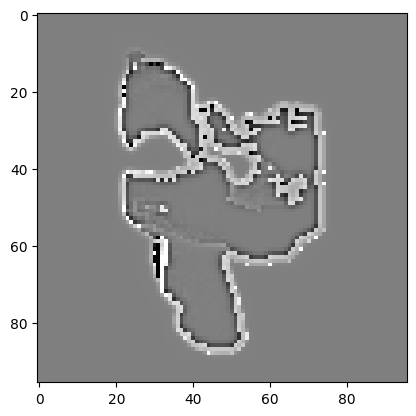

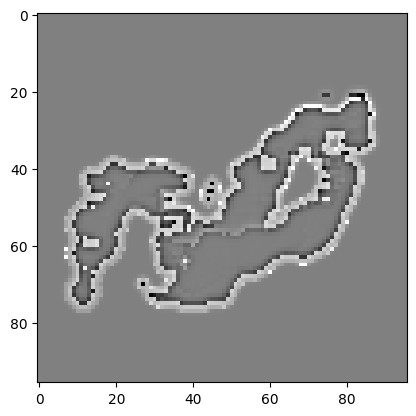

In [17]:
# Visualize sample
image, heatmap_gt = next(iter(val_dataloader))

plt.imshow(torch.squeeze(image[0], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt.show()

plt.imshow(torch.squeeze(image[50], 0).numpy(), cmap='gray', vmin=-1, vmax=1)
plt.show()

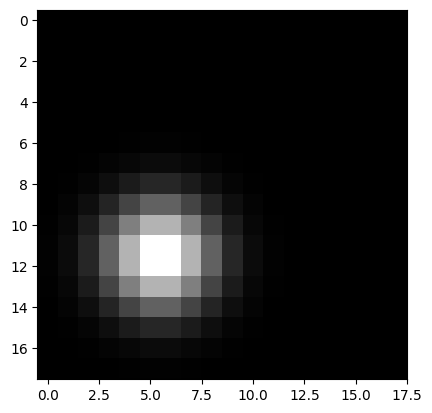

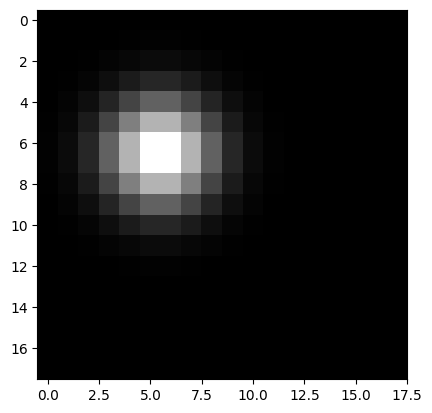

In [18]:
im_max = np.max(heatmap_gt[0][2].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[0][2], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.show()

im_max = np.max(heatmap_gt[100][2].cpu().numpy())
plt.imshow(torch.squeeze(heatmap_gt[100][2], 0).numpy() / im_max, cmap='gray', vmin=0, vmax=1)
plt.show()

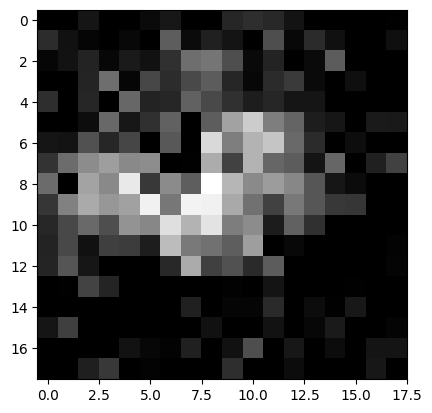

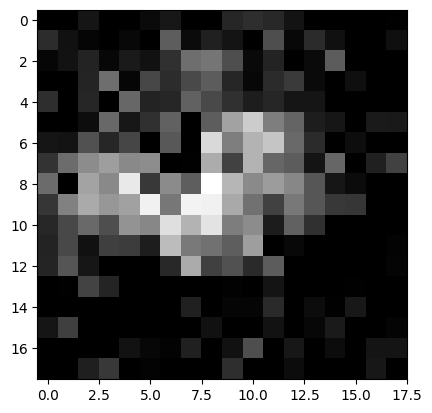

In [19]:
image = torch.unsqueeze(image.type(torch.FloatTensor).to(device), dim=1)
model.eval()
with torch.no_grad():
    pred = model(image)
    
    im_max = np.max(pred[0][2].cpu().numpy())
    plt.imshow(pred[0][2].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    im_max = np.max(pred[100][2].cpu().numpy())
    plt.imshow(pred[100][2].cpu().numpy() / im_max, cmap='gray', vmin=0, vmax=1)
    plt.show()